In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import os

In [6]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [7]:
# библиотека для работы с нейронными сетями
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

### Автоматическое дифференцирование в pytorch

1)

In [89]:
x = torch.randint(-5, 5, size=(5, 3)).float()
# При обратном проходе нужно вычислять градиенты по x
x.requires_grad = True
print('x.grad сейчас None:', x.grad is None)
x

x.grad сейчас None: True


tensor([[-5., -3., -3.],
        [-3.,  1., -2.],
        [ 0., -3.,  2.],
        [-1.,  4.,  2.],
        [-5., -5., -3.]], requires_grad=True)

In [70]:
y = torch.sum(2*x)
y

tensor(-28., grad_fn=<SumBackward0>)

$X.shape = (m, n), \ y = \sum\limits_{i, j} 2 \cdot x_{i, j} \Rightarrow \frac{\partial y}{\partial x_{i, j}} = 2 \Rightarrow \frac{\partial y}{\partial X} = 2 \cdot \mathbb{1}_{m, n}, \ $ где $\mathbb{1}_{m, n} = \left( 1\right)_{i, j = 1}^{m, n}$

In [71]:
y.backward()

In [72]:
x.grad

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

2)

In [94]:
x = torch.randint(-5, 5, size=(5, 3)).float()
# При обратном проходе нужно вычислять градиенты по x
x.requires_grad = True
y = torch.trace(torch.matmul(x.t(), x))
y

tensor(111., grad_fn=<TraceBackward>)

$y = tr(X^T X) \Rightarrow Dy[\Delta X] = tr((\nabla_{X}y)^T \Delta X) = tr(X^T \Delta X + \Delta X^T X) = tr(2X^T \Delta X) \Rightarrow \boxed{ \nabla_{X}y = 2 \cdot X } $

In [95]:
y.backward()

In [96]:
x.grad

tensor([[ -2.,  -6.,   2.],
        [  6.,  -6.,  -6.],
        [ -2.,   6.,   6.],
        [ -4.,   4., -10.],
        [ -2.,   4.,  -8.]])

In [97]:
2*x

tensor([[ -2.,  -6.,   2.],
        [  6.,  -6.,  -6.],
        [ -2.,   6.,   6.],
        [ -4.,   4., -10.],
        [ -2.,   4.,  -8.]], grad_fn=<MulBackward0>)

3)

In [140]:
x = torch.randint(1, 5, size=(4, 4)).float()
# При обратном проходе нужно вычислять градиенты по x
x.requires_grad = True
y = torch.log(torch.det(x))
y

tensor(4.3567, grad_fn=<LogBackward>)

$y = \log det(X) \Rightarrow \boxed{\nabla_{X}y = X^{-T}}$

In [142]:
y.backward()

In [143]:
x.grad

tensor([[ 0.2564, -0.2051,  0.1538, -0.1410],
        [ 0.1538,  0.0769, -0.3077,  0.1154],
        [-0.0769,  0.4615,  0.1538, -0.3077],
        [-0.2051, -0.4359,  0.0769,  0.5128]])

In [144]:
torch.inverse(x.t())

tensor([[ 0.2564, -0.2051,  0.1538, -0.1410],
        [ 0.1538,  0.0769, -0.3077,  0.1154],
        [-0.0769,  0.4615,  0.1538, -0.3077],
        [-0.2051, -0.4359,  0.0769,  0.5128]], grad_fn=<InverseBackward>)

4)

$y = \frac{1}{2} \Vert Ax + b \Vert_{2}^2 \Rightarrow \boxed{\frac{\partial y}{\partial A} = \nabla_{A} y = (Ax + b)x^{T}}, \ \boxed{\frac{\partial y}{\partial b} = \nabla_{b} y = Ax + b}$

In [193]:
x = torch.randint(1, 5, size=(5, 1)).float()
A = torch.randint(-3, 3, size=(3, 5)).float()
b = torch.randint(6, 8, size=(3, 1)).float()
A.requires_grad = True
b.requires_grad = True
y = 0.5*torch.norm(torch.matmul(A, x) + b)**2
y

tensor(193.5000, grad_fn=<MulBackward0>)

In [194]:
y.backward()

In [195]:
A.grad

tensor([[ 15.,  10.,  20.,  10.,  20.],
        [  3.,   2.,   4.,   2.,   4.],
        [-57., -38., -76., -38., -76.]])

In [196]:
# @ - вместо torch.matmul
(A @ x + b) @ x.t()

tensor([[ 15.,  10.,  20.,  10.,  20.],
        [  3.,   2.,   4.,   2.,   4.],
        [-57., -38., -76., -38., -76.]], grad_fn=<MmBackward>)

In [197]:
b.grad

tensor([[  5.],
        [  1.],
        [-19.]])

In [198]:
A @ x + b

tensor([[  5.],
        [  1.],
        [-19.]], grad_fn=<AddBackward0>)

### Задача 1 из семинара

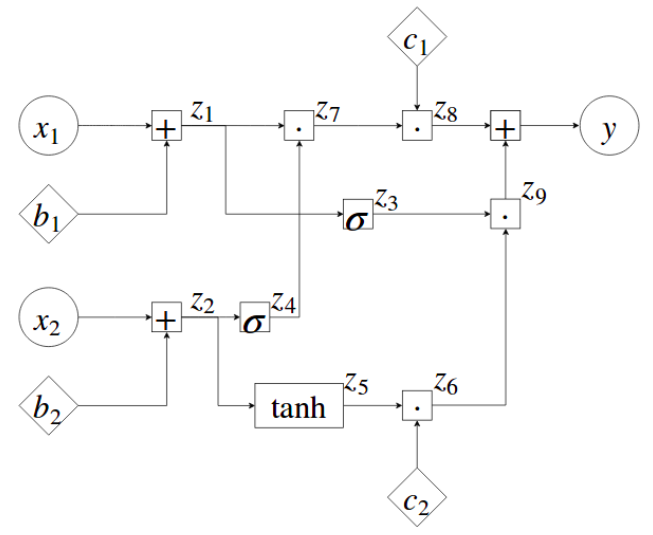

In [148]:
from IPython.display import Image
Image(filename='/Users/tony/Desktop/neural_nets_1.png') 

Для данного графа вычислений найдём производные выхода (y) по всем параметрам ($b_{1, 2}, \ c_{1, 2}$)

$z_{1} = x_{1} + b_{1}, \quad \frac{\partial z_{1}}{\partial b_{1}} = 1$

$z_{2} = x_{2} + b_{2}, \quad \frac{\partial z_{2}}{\partial b_{2}} = 1$

$z_{3} = \sigma(z_{1}), \quad \frac{\partial z_{3}}{\partial b_{1}} = \frac{\partial z_{3}}{\partial z_{1}} \cdot \frac{\partial z_{1}}{\partial b_{1}} = \sigma(z_{1})^{\prime}_{z_{1}} \cdot 1 = \sigma(z_{1}) \cdot \left(1 - \sigma(z_{1})\right)$

$z_{4} = \sigma(z_{2}), \quad \frac{\partial z_{4}}{\partial b_{2}} = \frac{\partial z_{4}}{\partial z_{2}} \cdot \frac{\partial z_{2}}{\partial b_{2}} = \sigma(z_{2})^{\prime}_{z_{2}} \cdot 1 = \sigma(z_{2}) \cdot \left(1 - \sigma(z_{2})\right)$

$z_{5} = \tanh(z_{2}), \quad \frac{\partial z_{5}}{\partial b_{2}} = \frac{\partial z_{5}}{\partial z_{2}} \cdot \frac{\partial z_{2}}{\partial b_{2}} = \tanh(z_{2})^{\prime}_{z_{2}} \cdot 1 = 1 - \tanh(z_{2})^2$

$z_{6} = c_{2} \cdot z_{5}, \quad \frac{\partial z_{6}}{\partial c_{2}} = z_{5}, \ \frac{\partial z_{6}}{\partial b_{2}} = \frac{\partial z_{6}}{\partial z_{5}} \cdot \frac{\partial z_{5}}{\partial z_{2}} \cdot \frac{\partial z_{2}}{\partial b_{2}} = c_{2} \cdot \tanh(z_{2})^{\prime}_{z_{2}} \cdot 1 = c_{2} \cdot \left(1 - \tanh(z_{2})^2 \right)$

$z_{7} = z_{4} \cdot z_{1}, \quad \frac{\partial z_{7}}{\partial b_{1}} = \frac{\partial z_{7}}{\partial z_{1}} \cdot \frac{\partial z_{1}}{\partial b_{1}} = z_{4} \cdot 1, \ \frac{\partial z_{7}}{\partial b_{2}} = \frac{\partial z_{7}}{\partial z_{4}} \cdot \frac{\partial z_{4}}{\partial z_{2}} \cdot \frac{\partial z_{2}}{\partial b_{2}} = z_{1} \cdot \sigma(z_{2})^{\prime}_{z_{2}} \cdot 1 = z_{1} \cdot \sigma(z_{2}) \cdot \left(1 - \sigma(z_{2})\right)$

$z_{8} = z_{7} \cdot c_{1}, \quad \frac{\partial z_{8}}{\partial c_{1}} = z_{7}, \ \frac{\partial z_{8}}{\partial b_{1}} = \frac{\partial z_{8}}{\partial z_{7}} \cdot \frac{\partial z_{7}}{\partial z_{1}} \cdot \frac{\partial z_{1}}{\partial b_{1}} = c_{1} \cdot z_{4} \cdot 1, \ \frac{\partial z_{8}}{\partial b_{2}} = \frac{\partial z_{8}}{\partial z_{7}} \cdot \frac{\partial z_{7}}{\partial z_{4}} \cdot \frac{\partial z_{4}}{\partial z_{2}} \cdot \frac{\partial z_{2}}{\partial b_{2}} = c_{1} \cdot z_{1} \cdot \sigma(z_{2})^{\prime}_{z_{2}} \cdot 1 = c_{1} \cdot z_{1} \cdot \sigma(z_{2}) \cdot \left(1 - \sigma(z_{2}) \right)$

$z_{9} = z_{3} \cdot z_{6}, \quad \frac{\partial z_{9}}{\partial b_{1}} = \frac{\partial z_{9}}{\partial z_{3}} \cdot \frac{\partial z_{3}}{\partial z_{1}} \cdot \frac{\partial z_{1}}{\partial b_{1}} = z_{6} \cdot \sigma(z_{1})^{\prime}_{z_{1}} \cdot 1, \ \frac{\partial z_{9}}{\partial c_{2}} = \frac{\partial z_{9}}{\partial z_{6}} \cdot \frac{\partial z_{6}}{\partial c_{2}} = z_{3} \cdot z_{5}, \ \frac{\partial z_{9}}{\partial b_{2}} = \frac{\partial z_{9}}{\partial z_{6}} \cdot \frac{\partial z_{6}}{\partial z_{5}} \cdot \frac{\partial z_{5}}{\partial z_{2}} \cdot \frac{\partial z_{2}}{\partial b_{2}} = z_{3} \cdot c_{2} \cdot \tanh(z_{2})^{\prime}_{z_{2}} \cdot 1$

Формула, по которой производится вычисление y выглядит следующим образом: 


$$y = z_{8} + z_{9} = \sigma(x_{2} + b_{2}) \cdot (x_{1} + b_{1}) \cdot c_{1} + \sigma(x_{1} + b_{1}) \cdot c_{2} \cdot \tanh(x_{2} + b_{2})$$

$\frac{\partial y}{\partial c_{1}} = \frac{\partial}{\partial c_{1}} (c_{1} \cdot z_{8}) = z_{8} = $

In [177]:
x1 = torch.FloatTensor([2])
x2 = torch.FloatTensor([-0.7])
b1 = torch.FloatTensor([0.3])
b1.requires_grad = True
b2 = torch.FloatTensor([0.01])
b2.requires_grad = True
c1 = torch.FloatTensor([-1])
c1.requires_grad = True
c2 = torch.FloatTensor([-5])
c2.requires_grad = True
for i in [b1, b2, c1, c2]:
    print(i.requires_grad)
print()
for i in [x1, x2]:
    print(i.requires_grad)

True
True
True
True

False
False


In [178]:
params = {'b1': b1, 'b2': b2, 'c1': c1, 'c2': c2}

In [179]:
y = c2 * torch.sigmoid(x1 + b1) * torch.tanh(x2 + b2) + c1 * (x1 + b1) * torch.sigmoid(x2 + b2)
y

tensor([1.9492], grad_fn=<AddBackward0>)

In [180]:
y.backward()

In [182]:
for param in params:
    print(param, params[param].grad)

b1 tensor([-0.0864])
b2 tensor([-3.4310])
c1 tensor([0.7683])
c2 tensor([-0.5435])


### Набор данных MNIST

In [2]:
%%time
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

CPU times: user 26.9 s, sys: 1.4 s, total: 28.3 s
Wall time: 32 s


In [3]:
data = np.hstack(
    (mnist.data, mnist.target.astype(int).reshape(-1, 1))
)
data_tensor = torch.DoubleTensor(data)

NameError: name 'torch' is not defined

Пример данных

Метка: 7


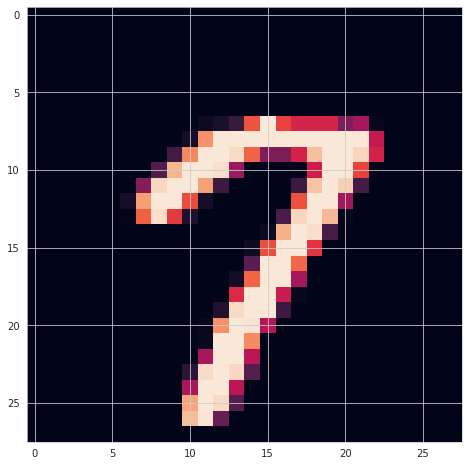

In [11]:
k = np.random.randint(len(data))
print('Метка:', int(data[k, -1]))
plt.imshow(data[k, :-1].reshape(28, 28));

### Классификация с помощью Полносвязной сети

In [14]:
split1, split2 = int(np.floor(data.shape[0]*0.6)), int(np.floor(data.shape[0]*0.85))
train_ids, val_ids, test_ids = np.split(
    np.arange(data.shape[0]), [split1, split2]
)

In [15]:
BATCH_SIZE = 100
train_iterator = DataLoader(torch.FloatTensor(data[train_ids]), 
                            batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(torch.FloatTensor(data[val_ids]), 
                          batch_size=BATCH_SIZE, shuffle=True)

In [29]:
class FFNet(nn.Module):
    def __init__(self, input_dim, layer1, layer2, layer3, layer4, layer5, output_dim):
        super(FFNet, self).__init__()
        self.hid_0_1 = nn.Linear(input_dim, layer1)
        self.hid_1_2 = nn.Linear(layer1, layer2)
        self.hid_2_out = nn.Linear(layer2, output_dim)
        
    def forward(self, x):
        out = F.relu(self.hid_0_1(x))
        out = F.relu(self.hid_1_2(out))
        out = self.hid_2_out(out)
        return out

In [30]:
INPUT_DIM = OUTPUT_DIM = data.shape[1] - 1
DEVICE = 'cuda'
TRAIN_BATCHES_LEN, VAL_BATCHES_LEN = int(np.floor(len(train_ids)/BATCH_SIZE)), int(np.floor(len(val_ids)/BATCH_SIZE))

In [31]:
model = FFNet(input_dim=INPUT_DIM, layer1=300, layer2=100, layer3=2, layer4=100, layer5=300, 
                    output_dim=10)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(params=model.parameters(), lr=1e-4)

In [40]:
EPOCHS = 100
model.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
val_loss = []
for epoch in tqdm(range(1, EPOCHS + 1)):
    st = time.perf_counter()
    model.to(DEVICE)
    current_loss = 0
    model.train()
    for batch in train_iterator:
        opt.zero_grad()
        x, y = batch[:, :-1].to(DEVICE), batch[:, -1].type(torch.LongTensor).to(DEVICE)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        current_loss += loss.item()/TRAIN_BATCHES_LEN
    train_loss.append(current_loss)
    
    model.eval()
    with torch.no_grad():
        current_loss = 0
        for batch in val_iterator:
            x, y = batch[:, :-1].to(DEVICE), batch[:, -1].type(torch.LongTensor).to(DEVICE)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            current_loss += loss.item()/VAL_BATCHES_LEN
        val_loss.append(current_loss)
    
    torch.save(model.cpu().state_dict(), 'epoch{}'.format(epoch))
    
    print('Epoch: {}'.format(epoch), 'train loss: {:.3f}'.format(train_loss[-1]), 
         'val loss: {:.3f}'.format(val_loss[-1]), 'Time: {}'.format(time.perf_counter() - st))

Epoch: 1 train loss: 0.690 val loss: 0.270 Time: 1.301254180725664
Epoch: 2 train loss: 0.187 val loss: 0.194 Time: 1.2482767761684954
Epoch: 3 train loss: 0.112 val loss: 0.164 Time: 1.1080742119811475
Epoch: 4 train loss: 0.076 val loss: 0.154 Time: 1.0820387317799032
Epoch: 5 train loss: 0.048 val loss: 0.139 Time: 1.1280172490514815
Epoch: 6 train loss: 0.033 val loss: 0.140 Time: 1.2406592443585396
Epoch: 7 train loss: 0.023 val loss: 0.131 Time: 1.4336741818115115
Epoch: 8 train loss: 0.016 val loss: 0.136 Time: 1.1995034161955118
Epoch: 9 train loss: 0.013 val loss: 0.136 Time: 1.095072089228779
Epoch: 10 train loss: 0.012 val loss: 0.137 Time: 1.041284924838692
Epoch: 11 train loss: 0.010 val loss: 0.133 Time: 1.0846017329022288
Epoch: 12 train loss: 0.017 val loss: 0.152 Time: 1.2681664880365133
Epoch: 13 train loss: 0.012 val loss: 0.151 Time: 1.2967818076722324
Epoch: 14 train loss: 0.008 val loss: 0.141 Time: 1.1620083269663155
Epoch: 15 train loss: 0.010 val loss: 0.172 Ti

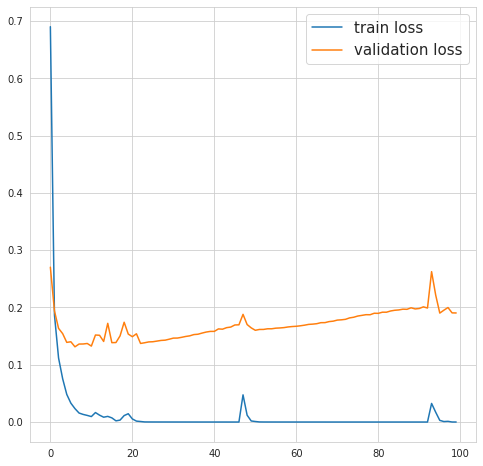

In [41]:
plt.plot(train_loss, label='train loss');
plt.plot(val_loss, label='validation loss');
plt.legend(fontsize=15);

Наблюдается переобучение - возьмём эпоху, на которой лосс на валидации был минимальным (11 эпоха)

In [43]:
model.cpu()
model.eval()
model.load_state_dict(torch.load('epoch11'))

<All keys matched successfully>

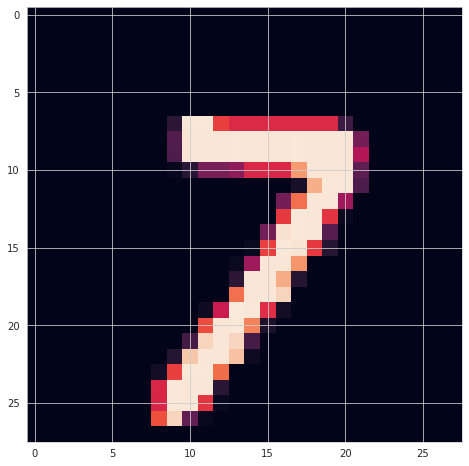

In [55]:
k = np.random.choice(test_ids)
test_digit, test_digit_class = data[k, :-1], data[k, -1]
plt.imshow(test_digit.reshape(28, 28));

In [56]:
with torch.no_grad():
    predict = torch.argmax(model(
    torch.FloatTensor(test_digit).reshape(1, -1)
)).item()
print('Прогнозная метка:', predict)

Прогнозная метка: 7


### Снижение размерности с помощью автокодировкщика

In [12]:
split1, split2 = int(np.floor(data.shape[0]*0.6)), int(np.floor(data.shape[0]*0.85))
train_ids, val_ids, test_ids = np.split(
    np.arange(data.shape[0]), [split1, split2]
)

In [13]:
BATCH_SIZE = 100
train_iterator = DataLoader(torch.FloatTensor(data[train_ids]), 
                            batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(torch.FloatTensor(data[val_ids]), 
                          batch_size=BATCH_SIZE, shuffle=True)

In [140]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, layer1, layer2, layer3, layer4, layer5, output_dim):
        super(AutoEncoder, self).__init__()
        self.hid_0_1 = nn.Linear(input_dim, layer1)
        self.hid_1_2 = nn.Linear(layer1, layer2)
        self.hid_2_3 = nn.Linear(layer2, layer3)
        self.hid_3_4 = nn.Linear(layer3, layer4)
        self.hid_4_5 = nn.Linear(layer4, layer5)
        self.hid_5_out = nn.Linear(layer5, output_dim)
        
    def encode(self, x):
        out = F.relu(self.hid_0_1(x))
        out = F.relu(self.hid_1_2(out))
        out = self.hid_2_3(out)
        return out
    
    def decode(self, x):
        out = F.relu(self.hid_3_4(F.relu(x)))
        out = F.relu(self.hid_4_5(out))
        out = self.hid_5_out(out)
        return out

In [174]:
INPUT_DIM = OUTPUT_DIM = data.shape[1] - 1
DEVICE = 'cuda'
TRAIN_BATCHES_LEN, VAL_BATCHES_LEN = int(np.floor(len(train_ids)/BATCH_SIZE)), int(np.floor(len(val_ids)/BATCH_SIZE))

In [175]:
model = AutoEncoder(input_dim=INPUT_DIM, layer1=300, layer2=100, layer3=2, layer4=100, layer5=300, 
                    output_dim=OUTPUT_DIM)
criterion = nn.MSELoss()
opt = optim.Adam(params=model.parameters(), lr=1e-4)

In [176]:
EPOCHS = 100
model.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
val_loss = []
for epoch in tqdm(range(1, EPOCHS + 1)):
    st = time.perf_counter()
    model.to(DEVICE)
    current_loss = 0
    model.train()
    for batch in train_iterator:
        opt.zero_grad()
        x, y = batch[:, :-1].to(DEVICE), batch[:, -1].reshape(-1, 1)
        x_encode = model.encode(x)
        x_reconstructed = model.decode(x_encode)
        loss = criterion(x_reconstructed, x)
        loss.backward()
        opt.step()
        current_loss += loss.item()/TRAIN_BATCHES_LEN
    train_loss.append(current_loss)
    
    model.eval()
    with torch.no_grad():
        current_loss = 0
        for batch in val_iterator:
            x, y = batch[:, :-1].to(DEVICE), batch[:, -1].reshape(-1, 1)
            x_encode = model.encode(x)
            x_reconstructed = model.decode(x_encode)
            loss = criterion(x_reconstructed, x)
            current_loss += loss.item()/VAL_BATCHES_LEN
        val_loss.append(current_loss)
    
    torch.save(model.cpu().state_dict(), 'epoch{}'.format(epoch))
    
    print('Epoch: {}'.format(epoch), 'train loss: {:.3f}'.format(train_loss[-1]), 
         'val loss: {:.3f}'.format(val_loss[-1]), 'Time: {}'.format(time.perf_counter() - st))

Epoch: 1 train loss: 4231.326 val loss: 3670.161 Time: 3.931615960318595
Epoch: 2 train loss: 3599.262 val loss: 3547.363 Time: 4.10120000038296
Epoch: 3 train loss: 3488.595 val loss: 3416.670 Time: 4.6061328877694905
Epoch: 4 train loss: 3376.898 val loss: 3328.148 Time: 4.584795571863651
Epoch: 5 train loss: 3317.814 val loss: 3292.783 Time: 4.158168509136885
Epoch: 6 train loss: 3278.467 val loss: 3259.974 Time: 4.058273315895349
Epoch: 7 train loss: 3245.446 val loss: 3231.995 Time: 4.70558077795431
Epoch: 8 train loss: 3214.914 val loss: 3202.222 Time: 4.155392295215279
Epoch: 9 train loss: 3185.862 val loss: 3174.989 Time: 4.176372942980379
Epoch: 10 train loss: 3160.564 val loss: 3153.262 Time: 4.525774999056011
Epoch: 11 train loss: 3140.411 val loss: 3136.424 Time: 4.430370904970914
Epoch: 12 train loss: 3119.573 val loss: 3119.604 Time: 4.12597580999136
Epoch: 13 train loss: 3103.894 val loss: 3111.288 Time: 4.462474999949336
Epoch: 14 train loss: 3087.947 val loss: 3093.391

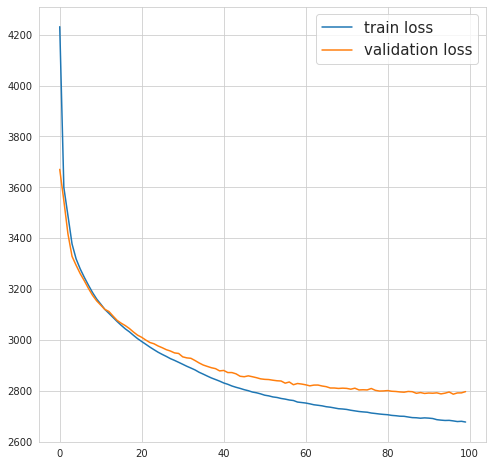

In [177]:
plt.plot(train_loss, label='train loss');
plt.plot(val_loss, label='validation loss');
plt.legend(fontsize=15);

In [ ]:
# for i in os.listdir():
#     if 'epoch' in i:
#         os.remove(i)

In [178]:
X_test = torch.FloatTensor(data[test_ids, :-1])
y_test = data[test_ids, -1].astype(int)
model_initialized = AutoEncoder(input_dim=INPUT_DIM, layer1=300, layer2=100, layer3=2, layer4=100, layer5=300, 
                    output_dim=OUTPUT_DIM)
model_initialized.to('cpu')

AutoEncoder(
  (hid_0_1): Linear(in_features=784, out_features=300, bias=True)
  (hid_1_2): Linear(in_features=300, out_features=100, bias=True)
  (hid_2_3): Linear(in_features=100, out_features=2, bias=True)
  (hid_3_4): Linear(in_features=2, out_features=100, bias=True)
  (hid_4_5): Linear(in_features=100, out_features=300, bias=True)
  (hid_5_out): Linear(in_features=300, out_features=784, bias=True)
)

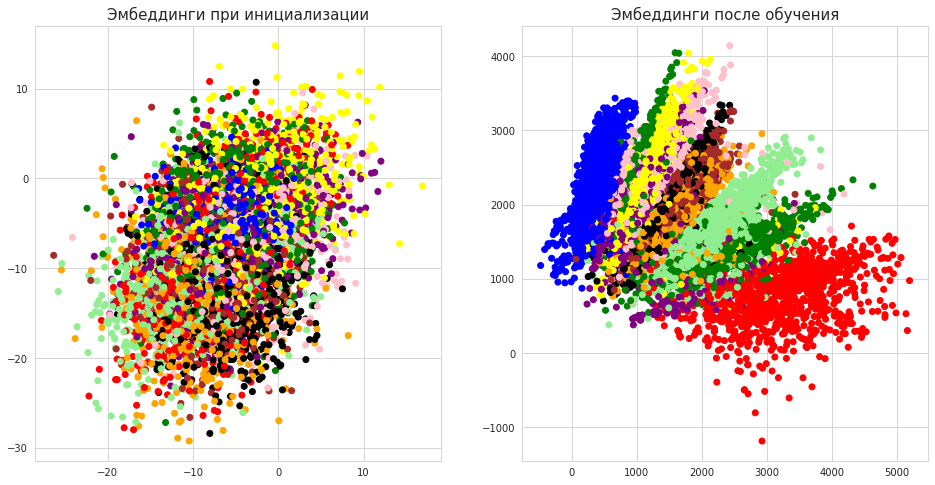

In [179]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
x_encoded = model_initialized.encode(X_test).detach().numpy()
ax[0].set_title('Эмбеддинги при инициализации', size=15);
ax[0].scatter(x_encoded[:, 0], x_encoded[:, 1], color=np.array([
    'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'lightgreen', 'black', 'pink', 'brown'
])[y_test]);
x_encoded = model.encode(X_test).detach().numpy()
ax[1].set_title('Эмбеддинги после обучения', size=15);
ax[1].scatter(x_encoded[:, 0], x_encoded[:, 1], color=np.array([
    'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'lightgreen', 'black', 'pink', 'brown'
])[y_test]);

Сравнение с PCA и TSNE

In [230]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [234]:
%%time
pc = PCA(n_components=2)
pc.fit(data[train_ids, :-1])
X_pc = pc.transform(data[train_ids, :-1])

CPU times: user 3.01 s, sys: 842 ms, total: 3.86 s
Wall time: 3.53 s


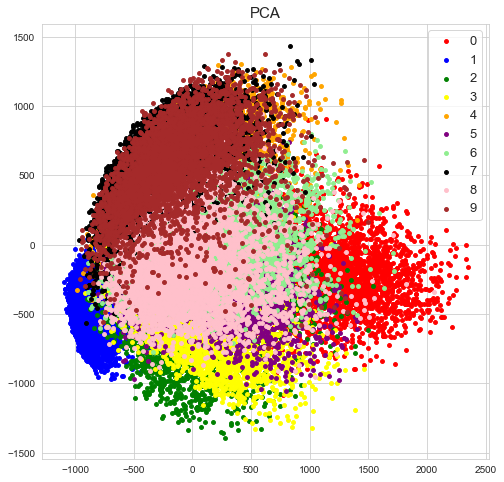

In [245]:
plt.title('PCA', fontsize=15);
colors = np.array(['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'lightgreen', 'black', 'pink', 'brown'])
for i in range(9+1):
    plt.scatter(X_pc[data[train_ids, -1] == i, 0], X_pc[data[train_ids, -1] == i, 1], color=colors[i], label=f'{i}',
               s=15);
    plt.legend(fontsize=13);

In [243]:
%%time
ts = TSNE(n_components=2, verbose=1)
subsample = data[np.random.choice(np.arange(len(data)), replace=False, size=10000)]
X_ts = ts.fit_transform(subsample[:, :-1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.787s...
[t-SNE] Computed neighbors for 10000 samples in 154.968s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 437.497196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.115929
[t-SNE] KL divergence after 1000 iterations: 1.843982
CPU times: user 6min 

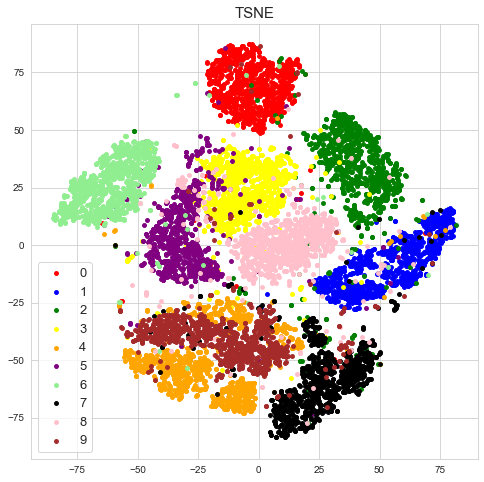

In [244]:
plt.title('TSNE', fontsize=15);
colors = np.array(['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'lightgreen', 'black', 'pink', 'brown'])
for i in range(9+1):
    plt.scatter(X_ts[subsample[:, -1] == i, 0], X_ts[subsample[:, -1] == i, 1], color=colors[i], label=f'{i}', 
                s=15);
    plt.legend(fontsize=13);

### Свёрточные сети

In [13]:
from PIL import Image, ImageDraw 

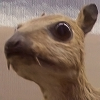

In [123]:
image = Image.open('/Users/tony/Desktop/Vd-Orig.png')
width, height = image.size
pix = image.load()
image_pixels = np.zeros((height, width, 3))
for i in tqdm_notebook(range(width)):
    for j in range(height):
        image_pixels[j, i] = pix[i, j]
image

In [124]:
from scipy.signal import convolve2d

In [279]:
granzes = np.array([[ -3-3j, 0-10j,  +3 -3j],
          [-10+0j, 0+ 0j, +10 +0j],
                    [ -3+3j, 0+10j,  +3 +3j]])

sharpen = np.array([
    [1, 1, 1],
    [1, -8, 1],
    [1, 1, 1]
])

sobel = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

In [280]:
image_conv1 = convolve2d(image_pixels[..., 0], granzes, boundary='symm', mode='same')
image_conv2 = convolve2d(image_pixels[..., 0], sharpen, boundary='symm', mode='same')
image_conv3 = convolve2d(image_pixels[..., 0], sobel, boundary='symm', mode='same')

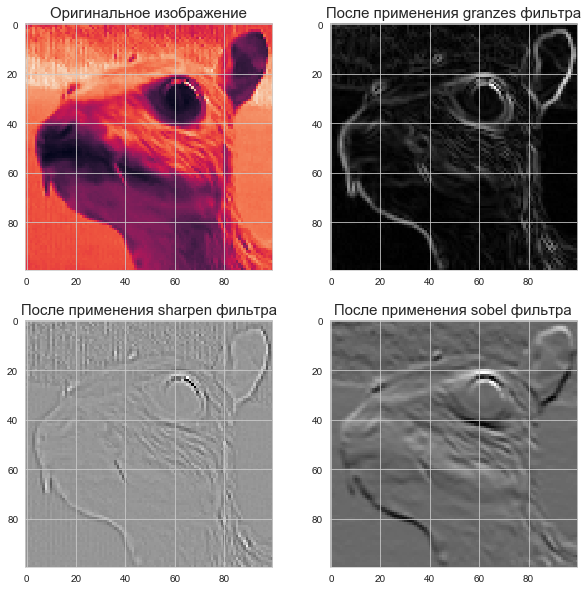

In [281]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].set_title('Оригинальное изображение', fontsize=15);
ax[0, 0].imshow(image_pixels[..., 0]);

ax[0, 1].set_title('После применения granzes фильтра', fontsize=15);
ax[0, 1].imshow(np.abs(image_conv1), cmap='gray');

ax[1, 0].set_title('После применения sharpen фильтра', fontsize=15);
ax[1, 0].imshow(image_conv2, cmap='gray');

ax[1, 1].set_title('После применения sobel фильтра', fontsize=15);
ax[1, 1].imshow(image_conv3, cmap='gray');

#### Свёртки в pytorch

In [283]:
# nn.Conv2d(
#     in_channels - количество входных каналов у изображения (у нашего RGB, то есть 3 канала)
#     out_channels - количество выходных каналов после применения свёртки
#     kernel_size - размер применяемой свёртки ( 3 х 3 например)
#     padding - сколько добавлять нулей после границы изображения:
#     Пример:
#            padding = 2 ->   0000000
#                             0000000
#                             0012300
#                             0045600
#                             0078900
#                             0000000
#                             0000000
#     stride - c каким шагом перемещать свёртку.
#     dilation - увеличивает область зависимости свёртки
# )

In [284]:
# expand - добавляем размерность BATCH_SIZE и назначаем её равно 1. permute - отправляем каналы (RGB) на 2 размерность
X = torch.FloatTensor(image_pixels).expand(size=[1, 100, 100, 3]).permute(0, 3, 1, 2)
kernel = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False)

In [285]:
kernel.weight.data = torch.FloatTensor([[
    [[-1, -1, -1],
     [-1, 8, -1],
     [-1, -1, -1]],
    
    [[-1, -1, -1],
     [-1, 8, -1],
     [-1, -1, -1]],
    
    [[-1, -1, -1],
     [-1, 8, -1],
     [-1, -1, -1]]
]])

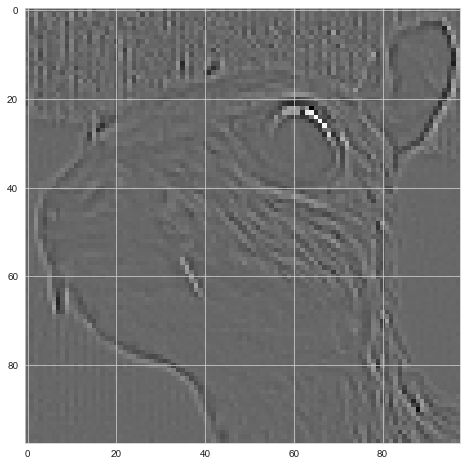

In [286]:
plt.imshow(kernel(X)[0, 0].detach().numpy(), cmap='gray');

#### Результаты свёрток с различными параметрами

In [342]:
example_matrix = torch.randint(-5, 5, size=(5, 5)).float().view(1, 1, 5, 5) #Batch_size, n_channels, height, width
example_matrix

tensor([[[[ 2., -4.,  2., -1.,  4.],
          [ 0.,  3., -2., -1., -3.],
          [ 2., -4., -5., -1., -5.],
          [-2., -4., -1.,  4.,  2.],
          [ 2.,  0.,  0.,  3.,  0.]]]])

kernel_size = (2, 2)

stride = 1

padding = 0

dilation = 1

In [343]:
example_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 2), bias=False)
example_conv.weight.data = torch.ones(size=(1, 1, 2, 2))
example_conv.weight.data

tensor([[[[1., 1.],
          [1., 1.]]]])

In [344]:
example_matrix

tensor([[[[ 2., -4.,  2., -1.,  4.],
          [ 0.,  3., -2., -1., -3.],
          [ 2., -4., -5., -1., -5.],
          [-2., -4., -1.,  4.,  2.],
          [ 2.,  0.,  0.,  3.,  0.]]]])

In [345]:
example_conv(example_matrix)

tensor([[[[  1.,  -1.,  -2.,  -1.],
          [  1.,  -8.,  -9., -10.],
          [ -8., -14.,  -3.,   0.],
          [ -4.,  -5.,   6.,   9.]]]], grad_fn=<MkldnnConvolutionBackward>)

kernel_size = (2, 2)

stride = 1

padding = 1

dilation = 1

In [346]:
example_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 2), padding=1, bias=False, )
example_conv.weight.data = torch.ones(size=(1, 1, 2, 2))
example_conv.weight.data

tensor([[[[1., 1.],
          [1., 1.]]]])

In [347]:
example_matrix

tensor([[[[ 2., -4.,  2., -1.,  4.],
          [ 0.,  3., -2., -1., -3.],
          [ 2., -4., -5., -1., -5.],
          [-2., -4., -1.,  4.,  2.],
          [ 2.,  0.,  0.,  3.,  0.]]]])

In [348]:
example_conv(example_matrix)

tensor([[[[  2.,  -2.,  -2.,   1.,   3.,   4.],
          [  2.,   1.,  -1.,  -2.,  -1.,   1.],
          [  2.,   1.,  -8.,  -9., -10.,  -8.],
          [  0.,  -8., -14.,  -3.,   0.,  -3.],
          [  0.,  -4.,  -5.,   6.,   9.,   2.],
          [  2.,   2.,   0.,   3.,   3.,   0.]]]],
       grad_fn=<MkldnnConvolutionBackward>)

kernel_size = (2, 2)

stride = 2

padding = 0

dilation = 1

In [349]:
example_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 2), padding=0, stride=2, bias=False)
example_conv.weight.data = torch.ones(size=(1, 1, 2, 2))
example_conv.weight.data

tensor([[[[1., 1.],
          [1., 1.]]]])

In [350]:
example_matrix

tensor([[[[ 2., -4.,  2., -1.,  4.],
          [ 0.,  3., -2., -1., -3.],
          [ 2., -4., -5., -1., -5.],
          [-2., -4., -1.,  4.,  2.],
          [ 2.,  0.,  0.,  3.,  0.]]]])

In [351]:
example_conv(example_matrix)

tensor([[[[ 1., -2.],
          [-8., -3.]]]], grad_fn=<MkldnnConvolutionBackward>)

kernel_size = (2, 2)

stride = 1

padding = 0

dilation = 2

In [356]:
example_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 2), padding=0, stride=1, dilation=2, 
                         bias=False)
example_conv.weight.data = torch.ones(size=(1, 1, 2, 2))
example_conv.weight.data

tensor([[[[1., 1.],
          [1., 1.]]]])

In [357]:
example_matrix

tensor([[[[ 2., -4.,  2., -1.,  4.],
          [ 0.,  3., -2., -1., -3.],
          [ 2., -4., -5., -1., -5.],
          [-2., -4., -1.,  4.,  2.],
          [ 2.,  0.,  0.,  3.,  0.]]]])

In [358]:
example_conv(example_matrix)

tensor([[[[  1., -10.,  -4.],
          [ -5.,   2.,  -4.],
          [ -1.,  -2., -10.]]]], grad_fn=<ConvDilated2DBackward>)

#### Обучение свёрточной нейросети

In [362]:
split1, split2 = int(np.floor(data.shape[0]*0.6)), int(np.floor(data.shape[0]*0.85))
train_ids, val_ids, test_ids = np.split(
    np.arange(data.shape[0]), [split1, split2]
)

In [363]:
BATCH_SIZE = 100
train_iterator = DataLoader(torch.FloatTensor(data[train_ids]), 
                            batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(torch.FloatTensor(data[val_ids]), 
                          batch_size=BATCH_SIZE, shuffle=True)

In [388]:
class ConvNet(nn.Module):
    
    def __init__(
         self, 
         out_channels1=10, 
         out_channels2=10, 
         kernel1=(5, 5), 
         kernel2=(3, 3), 
         pool_kernel1=(2, 2),
         pool_kernel2=(3, 3),
         output_dim=10
):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels1, kernel_size=kernel1)
        self.conv2 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=kernel2)
        self.last_layer = nn.Linear(in_features=out_channels2, out_features=output_dim)
        
    def forward(self, x):
        out = F.max_pool2d(self.conv1(x), kernel_size=pool_kernel1)
        out = F.max_pool2d(self.conv2(out), kernel_size=pool_kernel2)
        out = self.last_layer(out)
        return out

In [391]:
convnet_model = ConvNet()
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(convnet_model.parameters(), lr=1e-4)

In [ ]:
DEVICE = 'cpu'
EPOCHS = 100
model.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
val_loss = []
for epoch in tqdm_notebook(range(1, EPOCHS + 1)):
    st = time.perf_counter()
    model.to(DEVICE)
    current_loss = 0
    model.train()
    for batch in train_iterator:
        opt.zero_grad()
        x, y = batch[:, :-1].to(DEVICE), batch[:, -1].reshape(-1, 1)
        y_pred = model(x)
        loss = criterion(y_pred, x)
        loss.backward()
        opt.step()
        current_loss += loss.item()/TRAIN_BATCHES_LEN
    train_loss.append(current_loss)
    
    model.eval()
    with torch.no_grad():
        current_loss = 0
        for batch in val_iterator:
            x, y = batch[:, :-1].to(DEVICE), batch[:, -1].reshape(-1, 1)
            x_encode = model.encode(x)
            x_reconstructed = model.decode(x_encode)
            loss = criterion(x_reconstructed, x)
            current_loss += loss.item()/VAL_BATCHES_LEN
        val_loss.append(current_loss)
    
    torch.save(model.cpu().state_dict(), 'epoch{}'.format(epoch))
    
    print('Epoch: {}'.format(epoch), 'train loss: {:.3f}'.format(train_loss[-1]), 
         'val loss: {:.3f}'.format(val_loss[-1]), 'Time: {}'.format(time.perf_counter() - st))